In [39]:
import numpy as np
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')
# sys.path.insert(0, './algorithms')

## Import Wine Dataset

In [35]:
data = np.genfromtxt('data/winequality-white.csv',delimiter=';')[1:]
print(data.shape)

(4898, 12)


In [36]:
X = data[:,:11]
y = data[:,11]
print(X.shape, y.shape)

(4898, 11) (4898,)


In [37]:
def flatten(X):
    '''
    Flatten the data into a single list
    '''
    X_flat = []

    for x in X:
        X_flat += list(x)

    return np.array(X_flat)

def normalize(X):
    '''
    Normalize data
    '''
    X_flat = flatten(X)
    mu = X_flat.mean(axis=0)
    
    return [x - mu for x in X]

## Define Model
I used Logistic Regression in order to classify the wines according to some standard (1-10). Logistic Regression can be used to compute regression as well as classification. It is especially useful when the target is categorical.

NOTE: For multi-class classification, LR uses one-vs-rest mechanism to classify.


In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
X = normalize(X)
model = LogisticRegression(fit_intercept=False, dual= False)
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
import random as rand

subsets = []

for i in range(100):        
    subsets.append(rand.sample(list(data), 10))

subsets = np.asarray(subsets)
subsets.shape

(100, 10, 12)

## Given Loss Function

The loss function as detailed in the paper is implemented below.

In [43]:
# Detailed in the paper
def svm_loss(preds, ys, delta=0):
    '''
    Detailed in paper
    '''
    correct = ys.argmax()
    score_correct = preds[correct]
    
    loss = 0
    
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)            
            
    return loss

## Proposed Loss Function and Model

LR is now regularized with Ridge Regression and loss is calculated accordingly

In [50]:
model2 = LogisticRegression(fit_intercept=False, C=2, penalty='l2')
model2.fit(X, y)

def my_loss(preds, ys, delta = 0):
    correct = ys.argmax()
    score_correct = preds[correct]

    loss = 0
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)
    return loss

## Calculate Loss

In [51]:
# Calculate loss
loss = []
reg_loss = []
print("Computing losses...")
for subset in subsets:
    preds = model.predict(subset[:, :11])
    my_preds = model2.predict(subset[:, :11])

    score = np.argmax(preds)
    best_wine = subset[score][11]
    
    loss.append(svm_loss(preds, subset[:,11]))
    reg_loss.append(my_loss(my_preds, subset[:,11]))

Computing losses...


## Visualize results

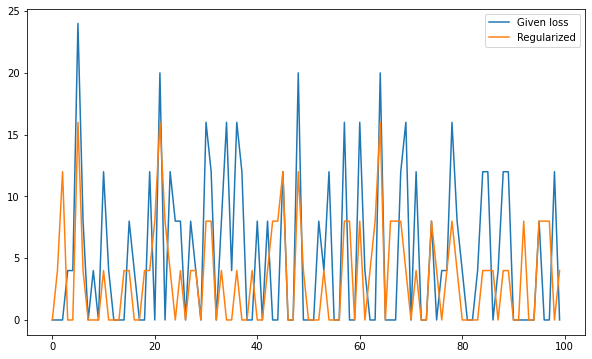

In [52]:
plt.figure(figsize=(10,6))
plt.plot(loss, label="Given loss")
plt.plot(reg_loss, label="Regularized")
plt.legend()
plt.show()